In [1]:
import ee
import pandas as pd
import matplotlib.pyplot as plt
import geemap
geemap.set_proxy(port=10809)
ee.Initialize()

In [2]:
geometry  = ee.FeatureCollection("projects/ee-mrwurenzhe/assets/ChinaShp/SouthestRegion")

# 定义时间范围
start_date = '2015-01-01'
end_date = '2024-12-31'

collection  = ee.ImageCollection('ASTER/AST_L1T_003') \
        .filterDate(start_date, end_date) \
        .filterBounds(geometry)

CLOUDY_PIXEL_PERCENTAGE = collection.reduceColumns(ee.Reducer.toList(),["CLOUDCOVER"]).get("list").getInfo()
Times_START = collection.reduceColumns(ee.Reducer.toList(),["system:time_start"]).get("list").getInfo()
Times_START = pd.to_datetime([t / 1000 for t in Times_START], unit='s')
cloud_df = pd.DataFrame({
    'Time': Times_START,
    'Cloud_Cover': CLOUDY_PIXEL_PERCENTAGE
})

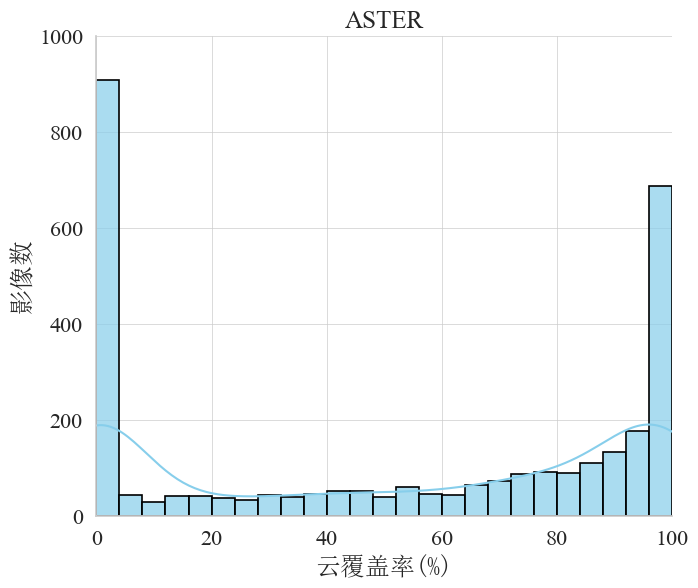

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import font_manager
sns.set_style('whitegrid')
my_font = font_manager.FontProperties(fname="C:/WINDOWS/Fonts/simsun.ttc")
my_font1 = font_manager.FontProperties(fname="C:/WINDOWS/Fonts/times.ttf")
x = cloud_df['Cloud_Cover']
bins = np.linspace(0, 100, 26)[:-1]
digitized = np.digitize(x, bins)
counts = pd.Series(digitized).value_counts().sort_index()
max_count = counts.max()
sns.displot(x, bins=25, kde=True, color='skyblue', linewidth=1.2, alpha=0.7, height=6, aspect=1.2,edgecolor='black')
plt.subplots_adjust(top=0.92, right=0.95, bottom=0.12, left=0.15)
plt.title('ASTER', fontproperties=my_font1, fontsize=18)
plt.xlabel('云覆盖率(%)', fontproperties=my_font, fontsize=18)
plt.ylabel('影像数', fontproperties=my_font, fontsize=18)
max_ytick = int(max_count / 500 + 1) * 500
plt.yticks(range(0, max_ytick + 200, 200), fontproperties=my_font1, size=16)
plt.xlim(0, 100)
plt.xticks(fontproperties=my_font1, size=16)
plt.grid(True, which='both', linestyle='-', linewidth=0.5)
plt.savefig('Aster_Cloud_Cover_Distribution.svg', format='svg', dpi=1200, bbox_inches='tight')
plt.show()

Total sum of image counts: 3057


C:\Users\A\AppData\Local\Temp\ipykernel_18760\749519207.py:19: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  cbar.ax.set_yticklabels(cbar.ax.get_yticklabels(), fontproperties=my_font1, fontsize=16)


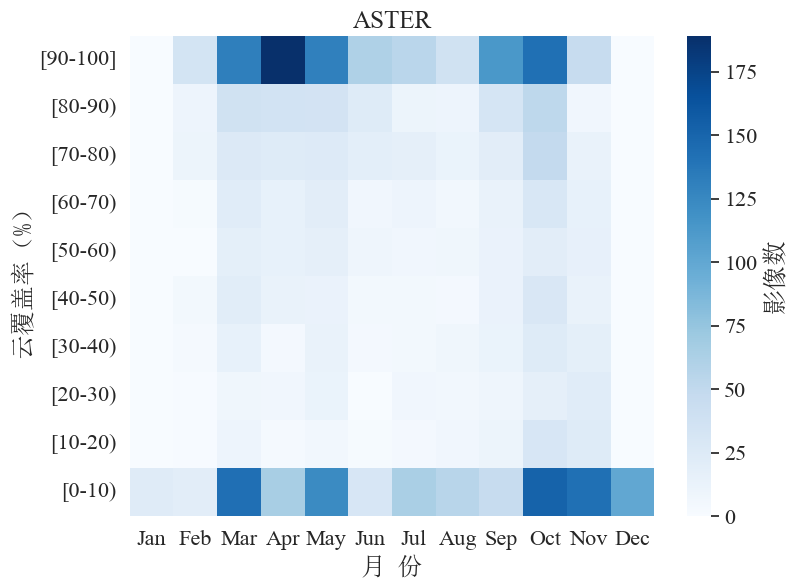

In [5]:
import calendar
cloud_df['日期'] = pd.to_datetime(cloud_df['Time'], unit='ms')
cloud_df['月份'] = cloud_df['日期'].dt.month
bins = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 101]
labels = ['[0-10)', '[10-20)', '[20-30)', '[30-40)', '[40-50)', '[50-60)', '[60-70)', '[70-80)', '[80-90)', '[90-100]']
cloud_df['云量区间'] = pd.cut(cloud_df['Cloud_Cover'], bins=bins, labels=labels, right=False)
result = pd.pivot_table(cloud_df, values='Cloud_Cover', index='云量区间', columns='月份',
                        aggfunc='count', fill_value=0)
result_array = result.to_numpy()
flipped_array = np.flipud(result_array)
total_sum = np.sum(flipped_array)
print(f"Total sum of image counts: {total_sum}")
sns.set(font_scale=1.2)
plt.figure(figsize=(8, 6))
heatmap = sns.heatmap(flipped_array, cmap='Blues', cbar_kws={'label': 'Count'},
                        yticklabels=list(reversed(result.index)))
plt.subplots_adjust(top=0.92, right=0.98, bottom=0.12, left=0.16)
cbar = heatmap.collections[0].colorbar
cbar.ax.set_yticklabels(cbar.ax.get_yticklabels(), fontproperties=my_font1, fontsize=16)
cbar.set_label('影像数', fontproperties=my_font, fontsize=18)
month_abbr = [calendar.month_abbr[i] for i in range(1, 13)]
heatmap.set_xticklabels(month_abbr, fontproperties=my_font1, rotation=0, fontsize=16)
heatmap.set_yticklabels(np.flipud(labels), fontproperties=my_font1, rotation=0, fontsize=16)
plt.title('ASTER', fontproperties=my_font1, fontsize=18)
plt.xlabel('月 份', fontproperties=my_font, fontsize=18)
plt.ylabel('云覆盖率（%）', fontproperties=my_font, fontsize=18)
plt.savefig('Aster_Cloud_Cover_Distribution-1.svg', dpi=1200, bbox_inches='tight')
plt.show()